### References

[1] Stereo signal separation and upmixing by mid-side decomposition in the frequency-domain

[2] Virtual sound source positioning using vector base amplitude panning

### Panning coefficient estimation

However, for typical music mixes the amplitude of the ambient signal $N$ is far less than the amplitude of the direct signal $D$. This also means that the left and right channels.

$$
|X_L| \approx \alpha_L \cdot |D| = \alpha_L \cdot |D| + \alpha_L \cdot |N| \\
|X_R| \approx \alpha_R \cdot |D| = \alpha_R \cdot |D| + \alpha_R \cdot |N| \\
$$

$$
{\alpha_L}^2 + {\alpha_R}^2 = 1
$$

With above information, the panning coefficients $\alpha_L$ and $\alpha_R$ can be estimated by $X_L$ and $X_R$:

$$
\hat{\alpha_L} = \frac{|X_L|}{\sqrt{|X_L|^2 + |X_R|^2}} \\
\hat{\alpha_R} = \frac{|X_R|}{\sqrt{|X_L|^2 + |X_R|^2}}
$$

The "stereophonic law of sines"

$$
\frac{|X_R| - |X_L|}{|X_R| + |X_L|} = \frac{sin\theta_I}{sin\theta_A} = \frac{sin\theta_I}{sin(\theta_0/2)} = -\hat{\Psi}
$$

$$
\begin{align}
f(x)^2 + g(x)^2 = 1 \tag{1} \\
\frac{f(x) - g(x)}{f(x) + g(x)} = x \tag{2} \\
f(0) = \frac{\sqrt{2}}{2} \tag{3} \\
g(0) = \frac{\sqrt{2}}{2} \tag{4} \\
\end{align}
$$

Assume $A(x) = f(x) - g(x)$ and $B(x) = f(x) + g(x)$, so we can revise $1$ and $2$ into:

$$
\begin{align}
\frac{A(x)}{B(x)} = x \tag{5} \\
A(x)^2 + B(x)^2 = 2 \tag{6} \\
\end{align}
$$

From $5$ and $6$, we can get:

$$
\begin{align}
\frac{2-B(x)^2}{B(x)^2} &= x^2           \\
B(x)^2x^2 + B(x)^2 &= 2                  \\
B(x)^2(x^2+1) &= 2                       \\
B(x)^2 &= \frac{2}{x^2 + 1}              \\
B(x) &= \frac{\sqrt{2   }}{\sqrt{x^2+1}} \tag{7} \\
A(x) &= \frac{\sqrt{2x^2}}{\sqrt{x^2+1}} \tag{8} \\
\end{align}
$$


With $7$ and $8$, we can derive $f(x)$ and $g(x)$:

$$
\begin{align}
f(x) = \frac{A(x) + B(x)}{2} &= \frac{\sqrt{\frac{2}{x^2+1}} + \sqrt{\frac{2x^2}{x^2+1}}}{2} \\
                             &= \frac{\sqrt{2} + \sqrt{2x^2}}{2\sqrt{x^2+1}} \\
                             &= \frac{\sqrt{2} + \sqrt{2}x}{2\sqrt{x^2+1}} \\
                             &= \frac{\sqrt{2}(1+x)}{2\sqrt{x^2+1}} \\
                             &= \frac{1+x}{\sqrt{2x^2+2}} \tag{9} \\
g(x) = \frac{B(x) - A(x)}{2} &= \frac{1-x}{\sqrt{2x^2+2}} \tag{10} \\
\end{align}
$$

In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read
import random

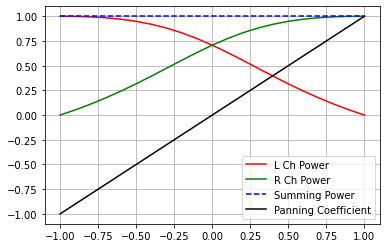

In [2]:
x = np.linspace(-1, 1, num=21, endpoint=True)

a_L = (1-x)/np.sqrt(2 * x * x + 2)
a_R = (1+x)/np.sqrt(2 * x * x + 2)

plt.plot(x, a_L, 'r', label = 'L Ch Power')
plt.plot(x, a_R, 'g', label = 'R Ch Power')
plt.plot(x, a_L * a_L + a_R * a_R, 'b--', label = 'Summing Power')
plt.plot(x, (a_R-a_L) / (a_R+a_L), 'k', label = 'Panning Coefficient')
plt.legend()
plt.grid()
plt.show()

In [3]:
rate, file = read("Bad Guy.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

start = 20
end = 40
data0 = data0[start * rate : end * rate]
data1 = data1[start * rate : end * rate]

plt.plot(data0)
plt.plot(data1)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Bad Guy.wav'

In [ ]:
def PreProcessData(xn, frameSize, stepSize):
    xn = np.append(np.zeros(128), xn)
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

In [ ]:
def gaussian():
    R1 = random.random()
    R2 = random.random()
    return np.sqrt(-2 * np.log(R1)) * np.cos(2*pi*R2)

In [ ]:
# -48dB - 6dB
RA = -15
FA = -24
FS = -16
_RA = np.power(10, (RA / 20))
_FA = np.power(10, (FA / 20))
_FS = np.power(10, (FS / 20))

M = 2048
H = 128
W = signal.get_window("hamming", M)

noise = []
for index in range(len(data0)):
    noise.append(gaussian() * np.power(10, (-120 / 20))) 

data0 = data0 + noise 
data1 = data1 + noise

dataSet0, data0, length, iteration = PreProcessData(data0, M, H)
dataSet1, data1, length, iteration = PreProcessData(data1, M, H)

width = np.exp(np.pi * 0.6 * np.complex128(1j))
rms = np.sqrt(2) / 2
minimum  = 2.2250738585072014e-308
minimum  = 0

In [ ]:
DIRECT = np.zeros(length)
DL = np.zeros(length)
DR = np.zeros(length)
DC = np.zeros(length)
NL = np.zeros(length)
NR = np.zeros(length)

aL_prev = np.zeros(M)
aR_prev = np.zeros(M)

for index in range(iteration):
    
    fL = np.fft.fft(dataSet0[index] * W)
    fR = np.fft.fft(dataSet1[index] * W)
    
    distance = np.sqrt(np.abs(fL) ** 2 + np.abs(fR) ** 2)
    
    aL = np.abs(fL) / (distance + minimum)
    aR = np.abs(fR) / (distance + minimum)

    direct = np.zeros(M, dtype = np.complex128)
    dc_mag = np.zeros(M, dtype = np.complex128)
    dl =     np.zeros(M, dtype = np.complex128)
    dr =     np.zeros(M, dtype = np.complex128)
    nl =     np.zeros(M, dtype = np.complex128)
    nr =     np.zeros(M, dtype = np.complex128)
    dc =     np.zeros(M, dtype = np.complex128)
    cl =     np.zeros(M, dtype = np.complex128)
    cr =     np.zeros(M, dtype = np.complex128)
    
    direct = (fL * width - fR) / (aL * width - aR + minimum)
    
    dl = direct * aL
    dr = direct * aR
    nl = fL - dl
    nr = fR - dr
    
    dc_mag = rms * ( np.abs(dl + dr) - np.abs(dl - dr))

    dc = ((dl + dr) * dc_mag) / (np.abs(dl + dr) + minimum) * rms
    cl = dl - dc
    cr = dr - dc

    temp0 = np.fft.ifft(direct).real * W
    temp1 = np.fft.ifft(fL).real * W
    temp2 = np.fft.ifft(fR).real * W
    temp3 = np.fft.ifft(dc).real * W
    temp4 = np.fft.ifft(nl).real * W
    temp5 = np.fft.ifft(nr).real * W
    
    start = index * H
    end = start + M
    
    DIRECT[start:end] = DIRECT[start : end] + temp0
    DL[start : end] = DL[start : end] + temp1
    DR[start : end] = DR[start : end] + temp2
    DC[start : end] = DC[start : end] + temp3
    NL[start : end] = NL[start : end] + temp4
    NR[start : end] = NR[start : end] + temp5

    
# assign output data to 5.1 format(L, R, C, LFE, LS, and RS)
Channel_1 = NL * _RA
Channel_2 = DL * _FS + NL * _FA
Channel_3 = DC * _FS
Channel_4 = DR * _FS + NR * _FA
Channel_5 = NR * _RA

In [ ]:
numerator= [1, -1]
denominator = [1, -0.95]

Channel_1 = signal.lfilter(numerator, denominator, Channel_1)
Channel_2 = signal.lfilter(numerator, denominator, Channel_2)
Channel_3 = signal.lfilter(numerator, denominator, Channel_3)
Channel_4 = signal.lfilter(numerator, denominator, Channel_4)
Channel_5 = signal.lfilter(numerator, denominator, Channel_5)

In [ ]:
plt.plot(Channel_1)
plt.ylim(-1,1)
plt.grid()
plt.show()
plt.plot(Channel_2)
plt.ylim(-1,1)
plt.grid()
plt.show()
plt.plot(Channel_3)
plt.ylim(-1,1)
plt.grid()
plt.show()
plt.plot(Channel_4)
plt.ylim(-1,1)
plt.grid()
plt.show()
plt.plot(Channel_5)
plt.grid()
plt.ylim(-1,1)
plt.show()

In [ ]:
write("Channel_1.wav", rate, (Channel_1 * 32767.0).astype(np.int16))
write("Channel_2.wav", rate, (Channel_2 * 32767.0).astype(np.int16))
write("Channel_3.wav", rate, (Channel_3 * 32767.0).astype(np.int16))
write("Channel_4.wav", rate, (Channel_4 * 32767.0).astype(np.int16))
write("Channel_5.wav", rate, (Channel_5 * 32767.0).astype(np.int16))

IPython.display.display(IPython.display.Audio("Channel_1.wav", rate=rate))
IPython.display.display(IPython.display.Audio("Channel_2.wav", rate=rate))
IPython.display.display(IPython.display.Audio("Channel_3.wav", rate=rate))
IPython.display.display(IPython.display.Audio("Channel_4.wav", rate=rate))
IPython.display.display(IPython.display.Audio("Channel_5.wav", rate=rate))